In [1]:
# %load honest_net.py
import numpy as np
import pandas as pd

import seaborn as sns

# Apply the default theme
sns.set_theme()

df = pd.read_csv("../../data/honest_net.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


# C&P from https://stackoverflow.com/a/39513799
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g


def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except TypeError:
        return np.array([float("nan")])


def expand(row):
    compute = parse_array(row.compute)
    weakest = np.argmin(compute)
    strongest = np.argmax(compute)
    d = {}

    def wsg(k, v):
        d[k + "_weakest"] = v[weakest]
        d[k + "_strongest"] = v[strongest]
        d[k + "_gini"] = gini(v)

    rcompute = compute / np.sum(compute)
    wsg("compute", rcompute)
    activations = parse_array(row.activations)
    assert np.sum(activations) == row.number_activations or row.error
    ractivations = activations / np.sum(activations)
    wsg("activations", ractivations)
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    wsg("reward", rreward)
    efficiency = rreward / ractivations
    wsg("efficiency", efficiency)
    d["activations_compute_gini_delta"] = d["activations_gini"] - d["compute_gini"]
    d["reward_activations_gini_delta"] = d["reward_gini"] - d["activations_gini"]
    return d


df = df.join(df.apply(expand, axis=1, result_type="expand"))

In [2]:
df.columns

Index(['network', 'network_description', 'compute', 'protocol', 'k',
       'protocol_description', 'block_interval', 'activation_delay',
       'number_activations', 'activations', 'incentive_scheme',
       'incentive_scheme_description', 'strategy', 'strategy_description',
       'reward', 'head_time', 'head_height', 'head_progress',
       'machine_duration_s', 'error', 'version', 'compute_weakest',
       'compute_strongest', 'compute_gini', 'activations_weakest',
       'activations_strongest', 'activations_gini', 'reward_weakest',
       'reward_strongest', 'reward_gini', 'efficiency_weakest',
       'efficiency_strongest', 'efficiency_gini',
       'activations_compute_gini_delta', 'reward_activations_gini_delta'],
      dtype='object')

## Protocol Implementations Checks

We have two implementations of the tailstorm protocol. They seem to produce differenct results. Let's first checks that what should be the same is the same.

### Progress

In [3]:
d = df.query('protocol in ["tailstormll", "tailstorm"]')

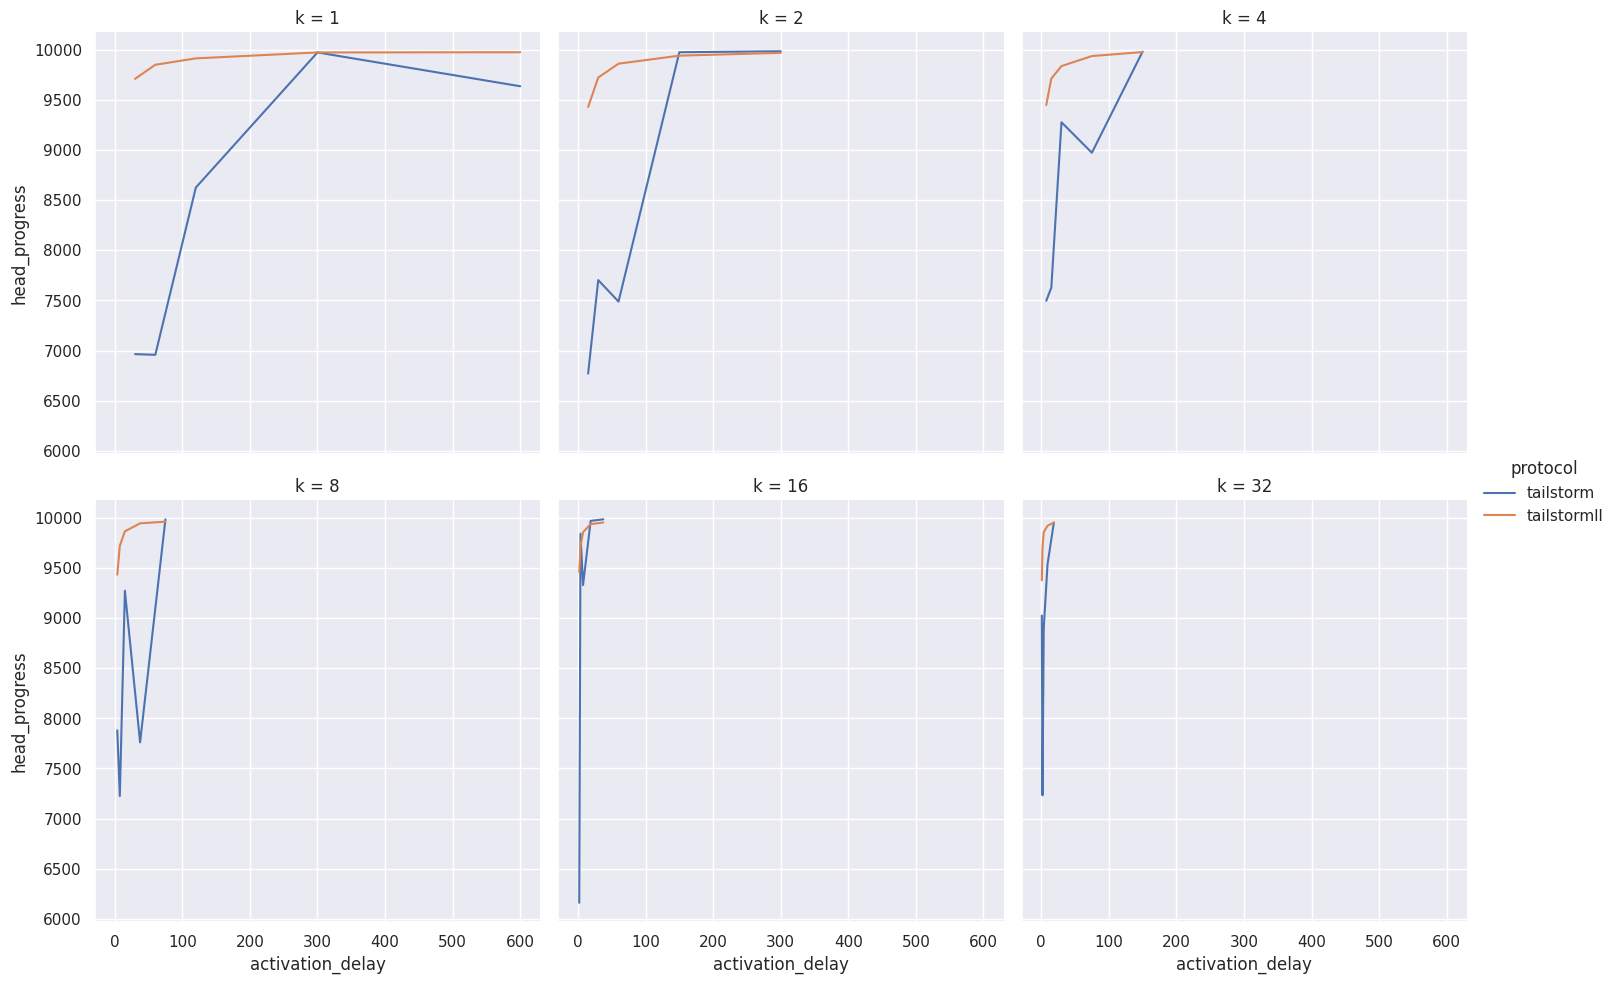

In [4]:
sns.relplot(
    data=d.query('incentive_scheme == "discount"'),
    x="activation_delay",
    y="head_progress",
    col="k",
    col_wrap=3,
    hue="protocol",
    kind="line",
)

## Incentive Schemes for Georges  Protocol

### Efficiency of the weakest miner

We pick the weakest miner by compute power and calculate its

efficiency = relative reward / relative activations

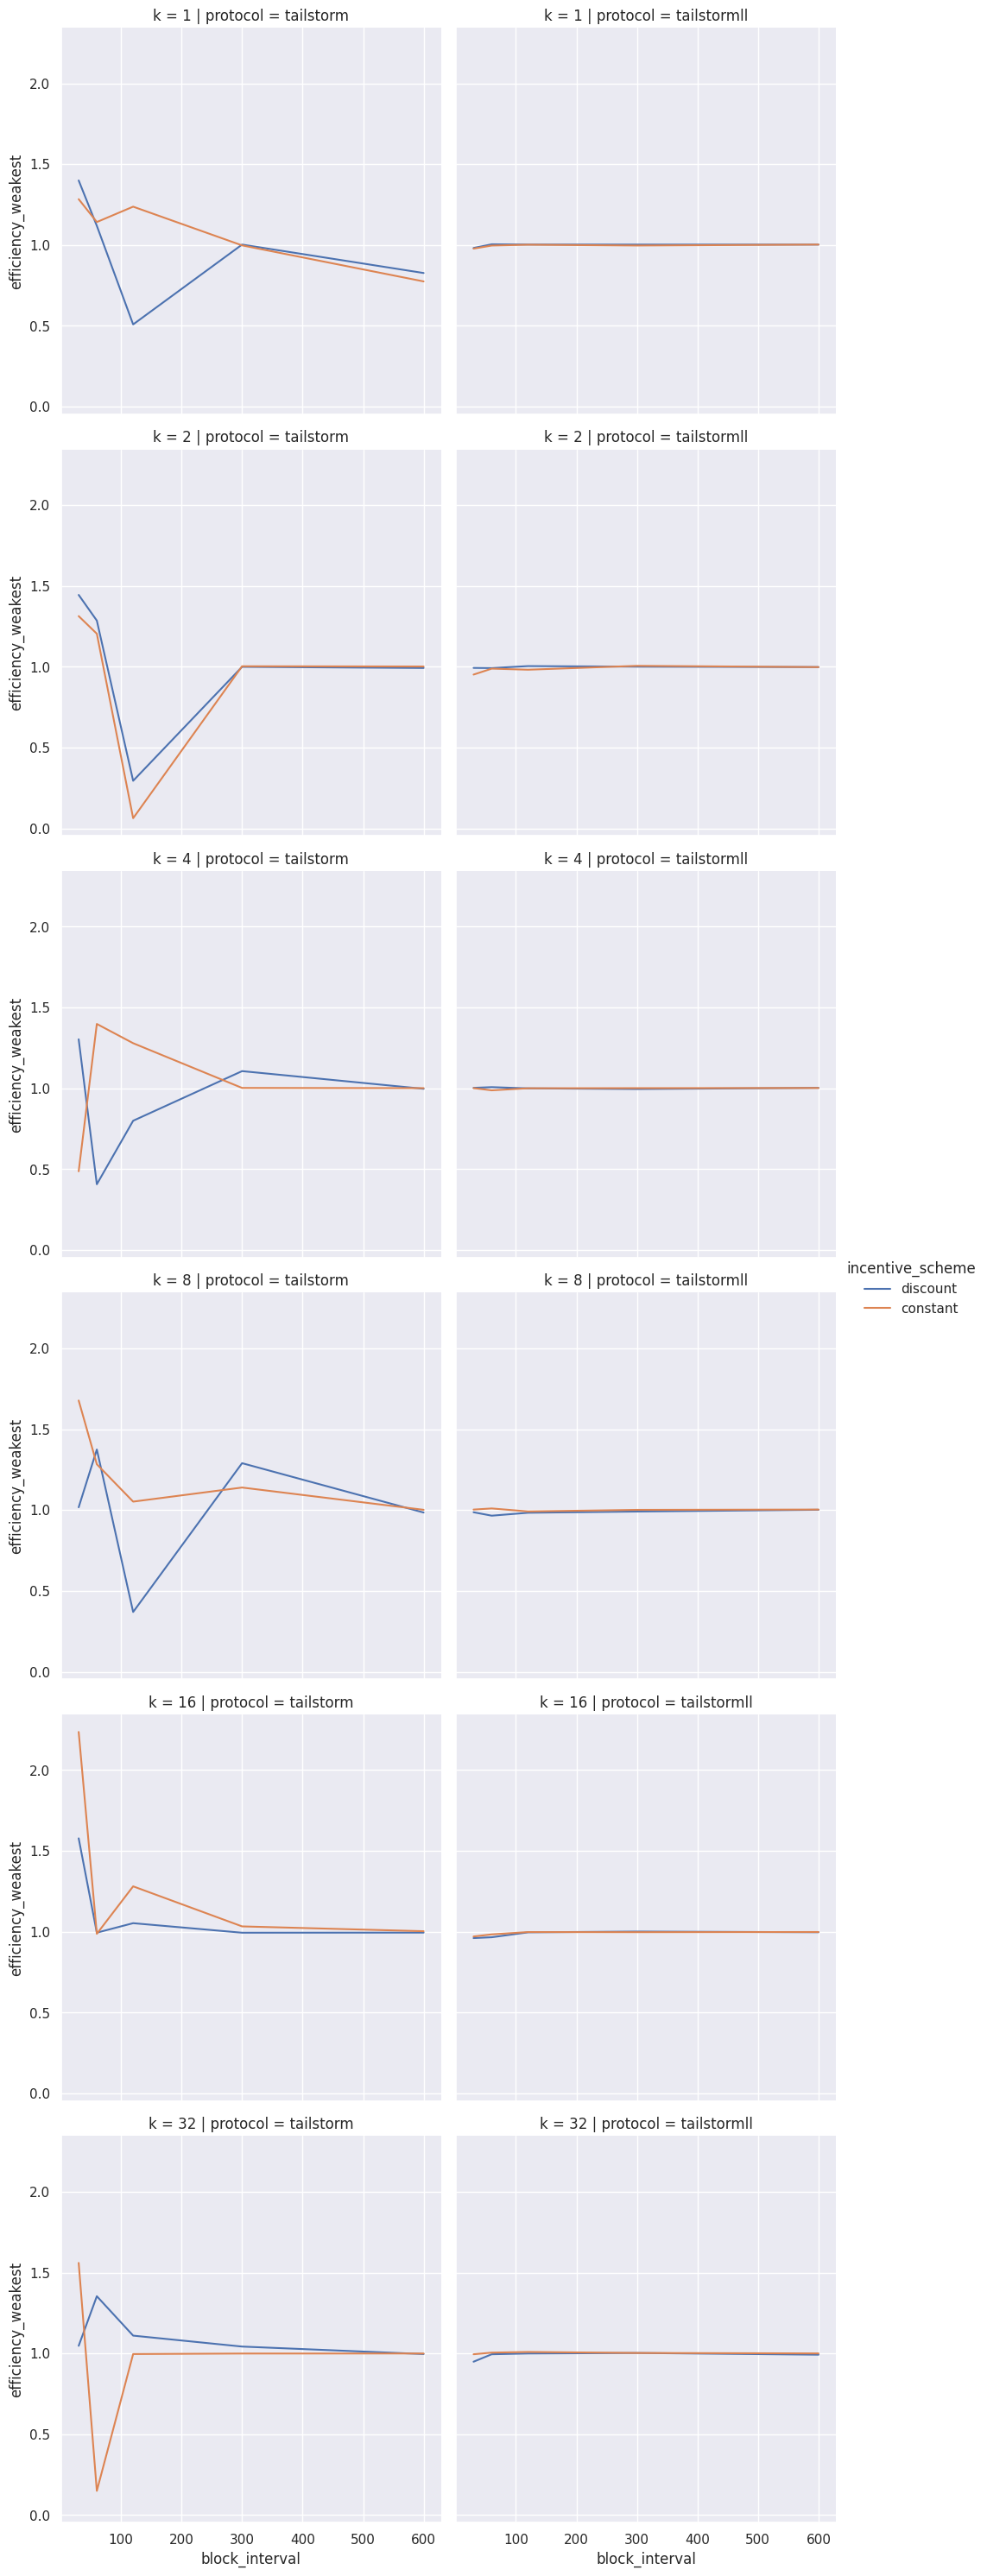

In [5]:
sns.relplot(
    data=d.query('incentive_scheme in ["constant", "discount"]'),
    x="block_interval",
    y="efficiency_weakest",
    col="protocol",
    row="k",
    hue="incentive_scheme",
    kind="line",
)

In [6]:
eff = d.rename(
    columns={"incentive_scheme": "Incentive Scheme", "block_interval": "Block Interval"}
).pivot(
    index=["Block Interval", "k", "protocol"],
    columns=["Incentive Scheme"],
    values="efficiency_weakest",
)
eff.style.to_latex(buf="../../tex/george-reward-inequality/tab/efficiency-weakest.tex")
eff

Incentive Scheme                  block  constant  discount    hybrid  \
Block Interval k  protocol                                              
30.0           1  tailstorm         NaN  1.283710  1.399371  0.383305   
                  tailstormll  1.024874  0.977805  0.981786  0.972338   
               2  tailstorm         NaN  1.312821  1.444086  0.839074   
                  tailstormll  1.040906  0.951240  0.992606  0.988282   
               4  tailstorm         NaN  0.487045  1.303565  1.700160   
                  tailstormll  1.053596  1.001595  1.003278  0.995599   
               8  tailstorm         NaN  1.677590  1.017192  0.997044   
                  tailstormll  1.157566  1.003021  0.986483  0.927299   
               16 tailstorm         NaN  2.235628  1.577709  0.087496   
                  tailstormll  1.111420  0.970583  0.960810  0.923678   
               32 tailstorm         NaN  1.559823  1.046965  1.498348   
                  tailstormll  0.832432  0.994713  0.948684  0.906217   
60.0           1  tailstorm         NaN  1.142149  1.118802  1.176189   
                  tailstormll  0.992087  0.996669  1.004587  1.003831   
               2  tailstorm         NaN  1.203990  1.285150  1.271470   
                  tailstormll  1.007511  0.988077  0.991671  1.006449   
               4  tailstorm         NaN  1.398507  0.406972  0.637165   
                  tailstormll  0.959846  0.987977  1.007616  0.992959   
               8  tailstorm         NaN  1.283245  1.374508  0.725997   
                  tailstormll  0.652673  1.009973  0.965225  0.924644   
               16 tailstorm         NaN  0.987160  0.994271  1.179141   
                  tailstormll  0.901730  0.983603  0.965874  0.960676   
               32 tailstorm         NaN  0.149719  1.353651  1.044850   
                  tailstormll  1.203245  1.004908  0.994727  0.861085   
120.0          1  tailstorm         NaN  1.237317  0.509014  1.261670   
                  tailstormll  1.003062  1.001927  1.003045  0.996212   
               2  tailstorm         NaN  0.063055  0.294398  1.157451   
                  tailstormll  0.965103  0.981417  1.003797  0.988126   
               4  tailstorm         NaN  1.279488  0.799851  1.237996   
                  tailstormll  0.973236  1.000705  1.000103  0.997839   
               8  tailstorm         NaN  1.052136  0.369559  1.014331   
                  tailstormll  0.742115  0.991473  0.983399  0.965862   
               16 tailstorm         NaN  1.280738  1.052917  1.038674   
                  tailstormll  1.411632  0.998068  0.996302  0.950293   
               32 tailstorm         NaN  0.995992  1.109999  1.099339   
                  tailstormll  0.863498  1.008910  0.999447  0.984041   
300.0          1  tailstorm         NaN  0.997812  1.002808  0.996337   
                  tailstormll  0.997502  0.996878  1.002808  0.991699   
               2  tailstorm         NaN  1.002808  0.999215  0.543194   
                  tailstormll  1.068398  1.005429  1.000221  1.005227   
               4  tailstorm         NaN  1.002808  1.106768  0.994640   
                  tailstormll  0.938272  1.001483  0.995901  1.008889   
               8  tailstorm         NaN  1.139337  1.289944  0.994217   
                  tailstormll  1.071545  1.001172  0.990912  1.014037   
               16 tailstorm         NaN  1.033058  0.993945  1.288044   
                  tailstormll  0.961377  0.997340  1.001107  0.971494   
               32 tailstorm         NaN  0.999210  1.042345  0.985192   
                  tailstormll  1.075269  1.002674  1.002654  0.953549   
600.0          1  tailstorm         NaN  0.774933  0.826976  1.033900   
                  tailstormll  1.001201  1.002808  1.002607  1.001502   
               2  tailstorm         NaN  1.001402  0.992063  0.997694   
                  tailstormll  0.961352  0.997558  0.997846  1.003009   
               4  tailstorm         NaN  1.001603  0.99732

### Reward Gini Fairness

We compare the rewards of all miners using the Gini coefficient. A lower coefficient implies more fairness. All numbers should be compared to the Gini coefficient of the compute powers.

In [7]:
d.compute_gini.unique()

array([0.3])

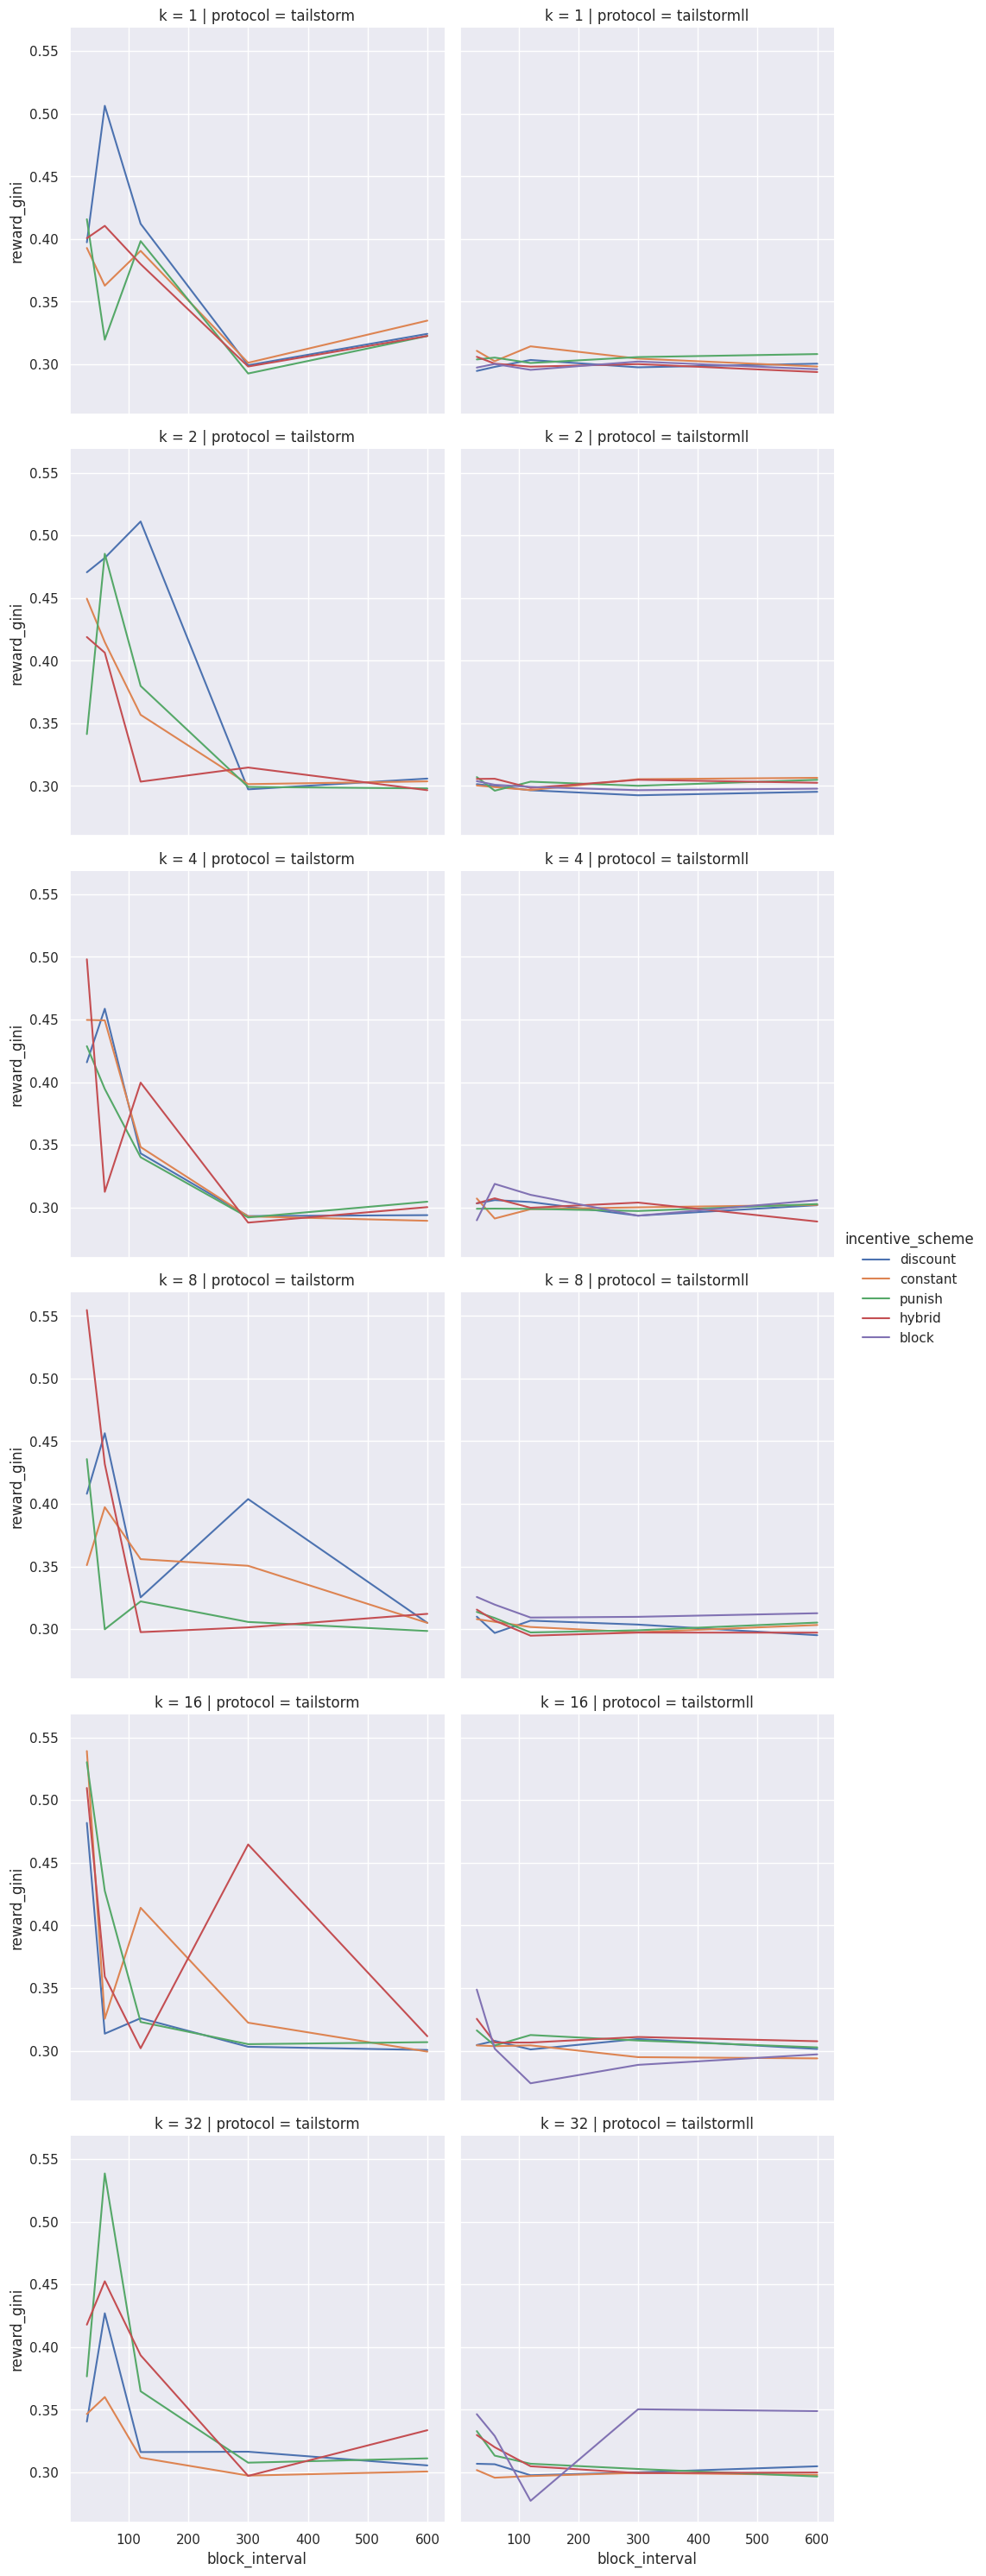

In [8]:
sns.relplot(
    data=d,
    x="block_interval",
    y="reward_gini",
    col="protocol",
    row="k",
    hue="incentive_scheme",
    kind="line",
)

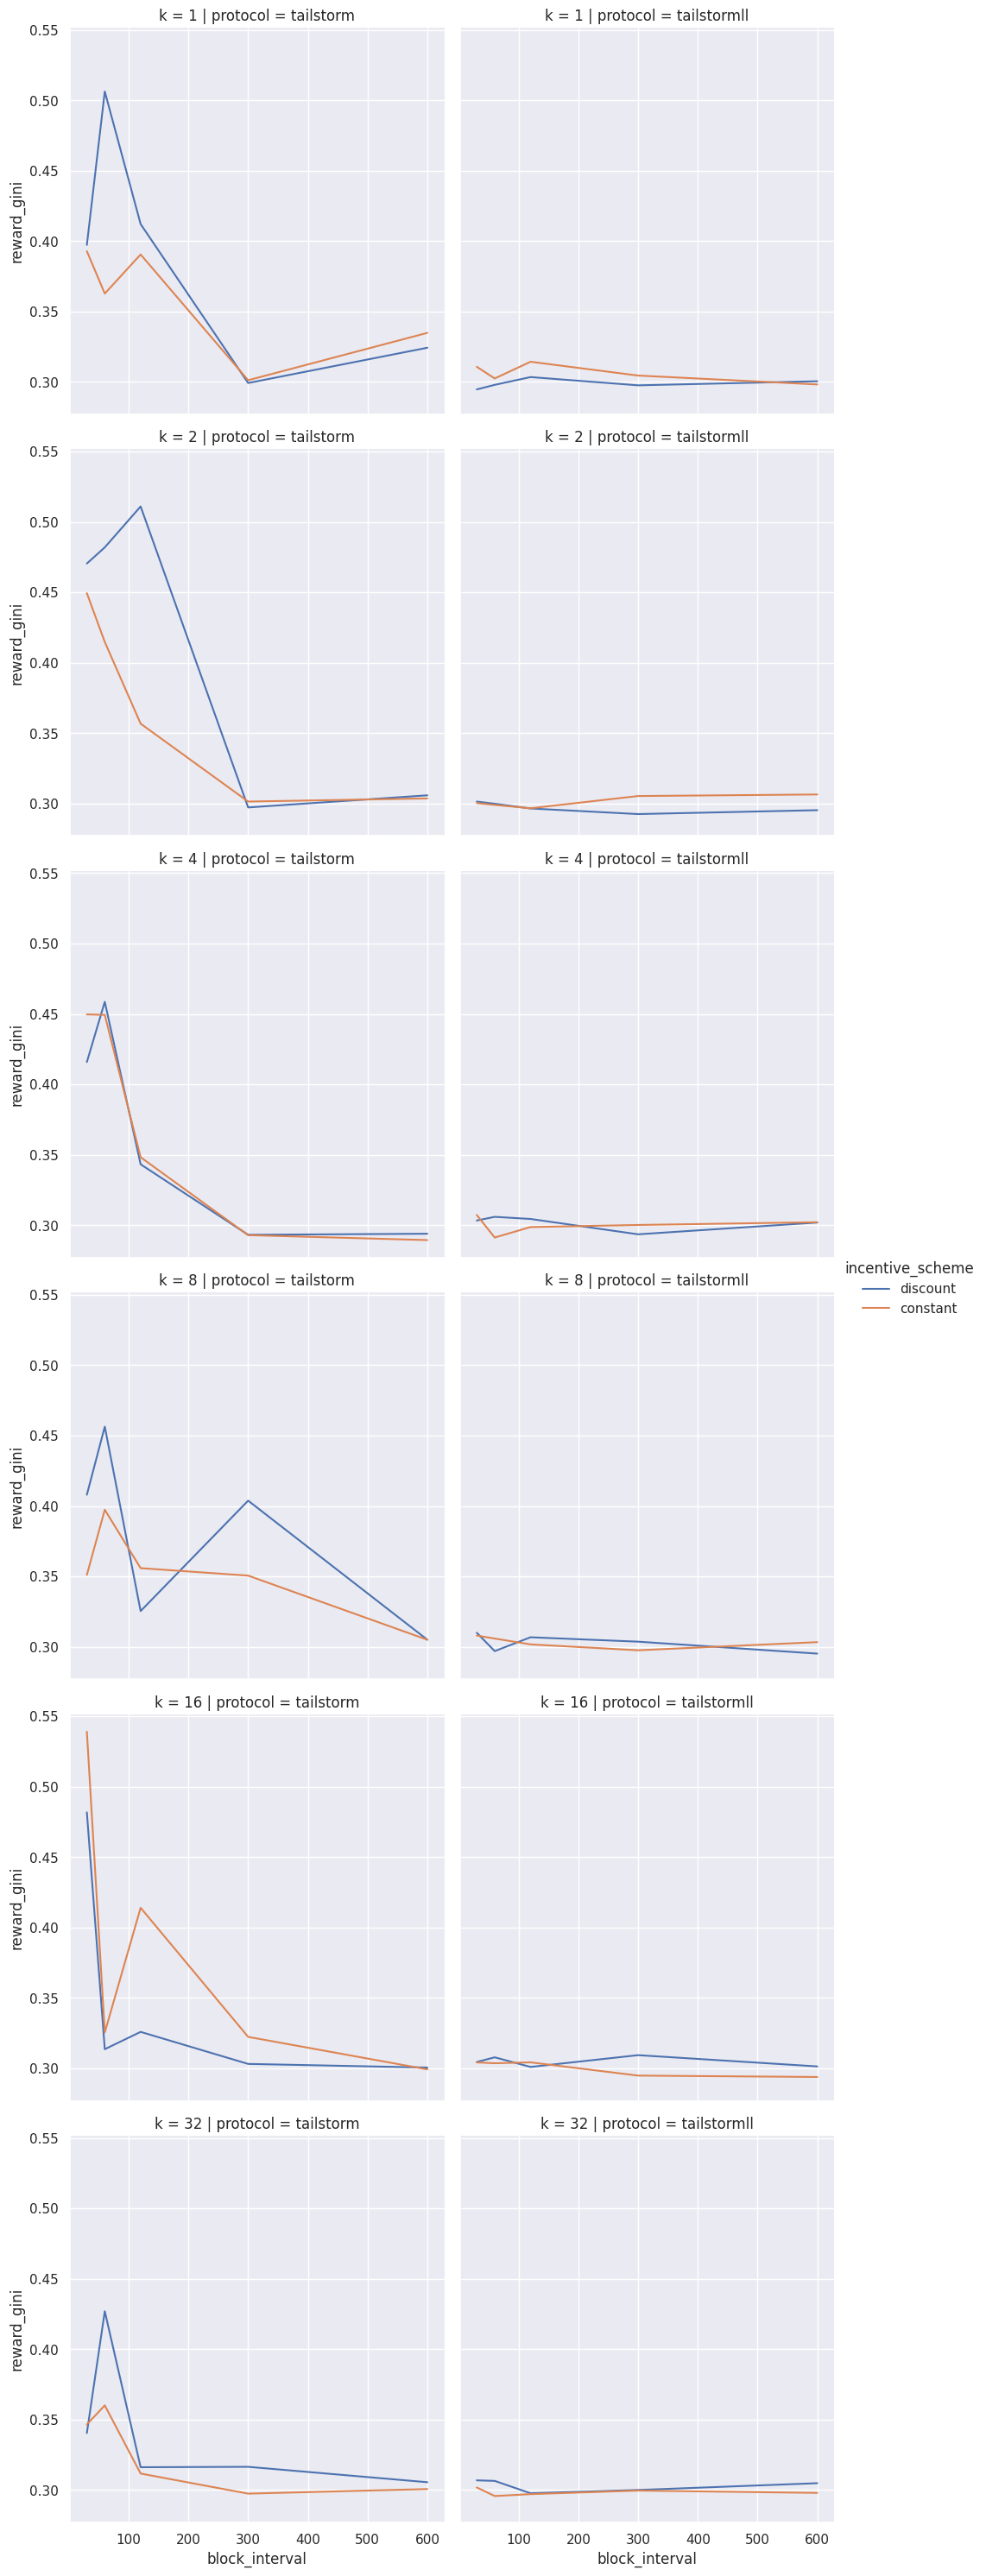

In [9]:
sns.relplot(
    data=d[
        (d["incentive_scheme"] == "constant") | (d["incentive_scheme"] == "discount")
    ],
    x="block_interval",
    y="reward_gini",
    col="protocol",
    row="k",
    hue="incentive_scheme",
    kind="line",
)

In [10]:
gini = d.rename(
    columns={"incentive_scheme": "Incentive Scheme", "block_interval": "Block Interval"}
).pivot(
    index=["Block Interval", "k", "protocol"],
    columns=["Incentive Scheme"],
    values="reward_gini",
)
gini.style.to_latex(buf="../../tex/george-reward-inequality/tab/reward-gini.tex")
gini

Incentive Scheme                  block  constant  discount    hybrid  \
Block Interval k  protocol                                              
30.0           1  tailstorm         NaN  0.392875  0.397358  0.400661   
                  tailstormll  0.297425  0.310802  0.294727  0.306031   
               2  tailstorm         NaN  0.449437  0.470496  0.418805   
                  tailstormll  0.303811  0.300382  0.301443  0.305612   
               4  tailstorm         NaN  0.449708  0.415892  0.498102   
                  tailstormll  0.289831  0.307197  0.303317  0.303376   
               8  tailstorm         NaN  0.351080  0.408008  0.554620   
                  tailstormll  0.325676  0.307986  0.309967  0.315594   
               16 tailstorm         NaN  0.539142  0.481801  0.509692   
                  tailstormll  0.348814  0.304258  0.304550  0.325470   
               32 tailstorm         NaN  0.346559  0.340466  0.417841   
                  tailstormll  0.346416  0.301792  0.306840  0.329787   
60.0           1  tailstorm         NaN  0.362791  0.506325  0.410528   
                  tailstormll  0.300263  0.302497  0.297969  0.300548   
               2  tailstorm         NaN  0.414779  0.481965  0.406356   
                  tailstormll  0.300947  0.299051  0.299897  0.305735   
               4  tailstorm         NaN  0.449350  0.458639  0.312527   
                  tailstormll  0.318871  0.291243  0.305934  0.307354   
               8  tailstorm         NaN  0.397329  0.456339  0.431778   
                  tailstormll  0.319572  0.305847  0.296937  0.306814   
               16 tailstorm         NaN  0.325512  0.313637  0.359163   
                  tailstormll  0.301650  0.303657  0.307869  0.306556   
               32 tailstorm         NaN  0.360079  0.426934  0.452464   
                  tailstormll  0.329043  0.295710  0.306459  0.320043   
120.0          1  tailstorm         NaN  0.390572  0.412162  0.379990   
                  tailstormll  0.295604  0.314374  0.303490  0.298168   
               2  tailstorm         NaN  0.356769  0.511028  0.303431   
                  tailstormll  0.299229  0.296687  0.296531  0.298438   
               4  tailstorm         NaN  0.348259  0.343231  0.399680   
                  tailstormll  0.310138  0.298679  0.304423  0.299813   
               8  tailstorm         NaN  0.355856  0.325372  0.297598   
                  tailstormll  0.309253  0.301707  0.306764  0.294780   
               16 tailstorm         NaN  0.414063  0.325924  0.301974   
                  tailstormll  0.274026  0.304282  0.301036  0.306534   
               32 tailstorm         NaN  0.311673  0.316172  0.393420   
                  tailstormll  0.277273  0.297058  0.297671  0.304846   
300.0          1  tailstorm         NaN  0.301264  0.299278  0.298257   
                  tailstormll  0.302226  0.304572  0.297633  0.300200   
               2  tailstorm         NaN  0.301444  0.297278  0.314698   
                  tailstormll  0.296620  0.305369  0.292555  0.304926   
               4  tailstorm         NaN  0.292920  0.293171  0.287969   
                  tailstormll  0.293481  0.300161  0.293526  0.303967   
               8  tailstorm         NaN  0.350550  0.403785  0.301405   
                  tailstormll  0.309831  0.297524  0.303638  0.297250   
               16 tailstorm         NaN  0.322376  0.303177  0.464602   
                  tailstormll  0.288728  0.294879  0.309396  0.310982   
               32 tailstorm         NaN  0.297408  0.316454  0.297158   
                  tailstormll  0.350323  0.299577  0.299999  0.299382   
600.0          1  tailstorm         NaN  0.334881  0.324328  0.322656   
                  tailstormll  0.296075  0.298255  0.300521  0.293851   
               2  tailstorm         NaN  0.303665  0.305869  0.296601   
                  tailstormll  0.297833  0.306479  0.295325  0.302508   
               4  tailstorm         NaN  0.289423  0.29393